# Check to see if scaled water rest has andersen thermostat

In [1]:
import pickle
import os
from openeye import oechem
from perses.annihilation.rest import RESTTopologyFactoryV2
from perses.annihilation.lambda_protocol import RESTStateV2
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor


INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:rdkit:Enabling RDKit 2021.03.3 jupyter extensions


In [5]:
phase = 'apo'
name = "arg"
state = 0

length = 1
move_length = 1
timestep = 4
radius = 0.4

outdir = "/data/chodera/zhangi/perses_benchmark/neq/20/30/"

In [7]:
# Load rhtf
i = os.path.basename(os.path.dirname(outdir))
path = os.path.join(outdir, f"{i}_{phase}_{state}.pickle")
htf = pickle.load(open(path, "rb" ))



In [11]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 83 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
factory = RESTTopologyFactoryV2(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.2004, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.2004, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.2004), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:REST:Handling constraints
INFO:REST:Handling bonds
INFO:REST:Handling angles
INFO:REST:Handling torsions
INFO:REST:Handling nonbondeds
INFO:REST:Handling nonbonded scaling (custom nb)
INFO:REST:Handling nonbonded exception scaling (custom bond)


In [13]:
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTStateV2.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

In [21]:
REST_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b238f059b40> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b2395561de0> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b23955618d0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b2395561930> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b23955619c0> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b2395561a50> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b2395561ae0> >]

In [14]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.
getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))


In [20]:
thermodynamic_state_list[0].get_system().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b238f059f90> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b238f059c60> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b238f059cf0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b23955617e0> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b2395561d80> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b2395561f30> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2b2395561e40> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b2395561d50> >]

# Check to see if normal rest has andersen thermostat

In [14]:
import pickle
import os
from openeye import oechem
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTState
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor


conducting subsequent work with the following platform: CUDA


In [15]:
phase = 'apo'
name = "arg"
state = 0

length = 1
move_length = 1
timestep = 4
radius = 0.4

outdir = "/data/chodera/zhangi/perses_benchmark/neq/20/30/"

In [16]:
# Load rhtf
i = os.path.basename(os.path.dirname(outdir))
path = os.path.join(outdir, f"{i}_{phase}_{state}.pickle")
htf = pickle.load(open(path, "rb" ))



In [17]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 83 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
factory = RESTTopologyFactory(htf.hybrid_system, solute_region=rest_atoms, use_dispersion_correction=True)

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.2004, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.2004, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.2004), unit=nanometer)]
INFO:REST:No unknown forces.


In [18]:
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTState.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

In [6]:
thermostate.set_system(REST_system)


ThermodynamicsError: System does not have a thermostat specifying the temperature.

In [49]:
thermostate.system.getForces()


[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b23b79e8d20> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b23b79e8de0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b23b79e8270> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b23b79e8630> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b23b79f8240> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2b23b79f8360> >]

In [43]:
thermostate._remove_thermostat(thermostate._standard_system)


In [33]:
REST_system.getForces()


[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b2393ca8330> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b2393ca8630> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b2393ca8210> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b238ecadae0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b23846b0210> >]

In [42]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.
getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))


In [23]:
thermodynamic_state_list[0].get_system().getForces()


[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b5569e0c210> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b5569e0c060> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b54de8d7960> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b5569e01de0> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2b5569e01cf0> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b5569e01f00> >]

In [9]:
import openmmtools

In [12]:
context_cache = cache.global_context_cache

In [29]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [20]:
context, integrator = context_cache.get_context(thermodynamic_state_list[0], integrator)


In [22]:
context.getSystem().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b5569e0cae0> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b5569e0c420> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b5569e0ca80> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b5569e0cb40> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b5569e0ccc0> >]

In [30]:
context = thermodynamic_state_list[0].create_context(integrator)

In [31]:
context.getSystem().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b556a12d660> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b556a12d600> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b556a12d780> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b5569deced0> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b5569dec720> >]

## Try running vanilla MD on the first thermostate and see if the problem happens

In [13]:
from tqdm import tqdm_notebook
import openmmtools

In [2]:
import pickle
import os
from openeye import oechem
from perses.annihilation.rest import RESTTopologyFactoryV2
from perses.annihilation.lambda_protocol import RESTStateV2
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
# cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor


INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


conducting subsequent work with the following platform: CUDA


INFO:rdkit:Enabling RDKit 2021.03.3 jupyter extensions


In [3]:
phase = 'apo'
name = "arg"
state = 0

length = 1
move_length = 1
timestep = 4
radius = 0.4

outdir = "/data/chodera/zhangi/perses_benchmark/neq/20/30/"

In [4]:
# Load rhtf
i = os.path.basename(os.path.dirname(outdir))
path = os.path.join(outdir, f"{i}_{phase}_{state}.pickle")
htf = pickle.load(open(path, "rb" ))



In [5]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 83 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
factory = RESTTopologyFactoryV2(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.2004, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.2004, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.2004), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:REST:Handling constraints
INFO:REST:Handling bonds
INFO:REST:Handling angles
INFO:REST:Handling torsions
INFO:REST:Handling nonbondeds
INFO:REST:Handling nonbonded scaling (custom nb)
INFO:REST:Handling nonbonded exception scaling (custom bond)


In [6]:
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTStateV2.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

In [7]:
REST_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b15f70d9c00> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b15f70d9f90> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b1680108f30> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b16801089c0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b15f6e7b690> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b15f6e7b630> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b15f6e7b0c0> >]

In [8]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))


In [9]:
thermodynamic_state_list[0].get_system().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b167100a570> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b167100a4b0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b15f6e704e0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b167dcf8540> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b167dcf84e0> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b167dcf8360> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2b167dcf8390> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b167dcf83c0> >]

In [10]:
context_cache = cache.global_context_cache

In [14]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [15]:
context, integrator = context_cache.get_context(thermodynamic_state_list[0], integrator)


In [16]:
context.getPlatform().getName()

'CUDA'

In [17]:
sampler_state_list[0].apply_to_context(context)

In [18]:
old, new = list(), list()
energies = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    
    energy = context.getState(getEnergy=True).getPotentialEnergy()
    energies.append(energy)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    old.append(old_pos)
    new.append(new_pos)

<ipython-input-18-10919d5420ff>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
with open("old.npy", 'wb') as f:
    np.save(f, old)
with open("new.npy", 'wb') as f:
    np.save(f, new)
with open("energies.npy", 'wb') as f:
    np.save(f, energies_cleaned)

In [20]:
import mdtraj as md

In [21]:
traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj.save("old.dcd")
traj[0].save("old.pdb")

In [22]:
import matplotlib.pyplot as plt

In [26]:
energies_cleaned = []
for energy in energies:
    energies_cleaned.append(energy.value_in_unit_system(unit.md_unit_system))

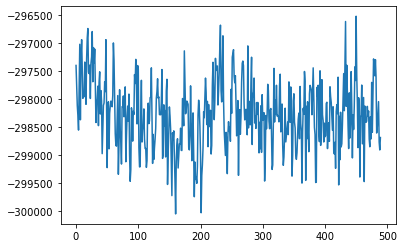

In [28]:
plt.plot(energies_cleaned[10:])

### Try running at 1200 K thermostate

In [30]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [31]:
context, integrator = context_cache.get_context(thermodynamic_state_list[-1], integrator)


In [32]:
context.getPlatform().getName()

'CUDA'

In [33]:
sampler_state_list[-1].apply_to_context(context)

In [36]:
old, new = list(), list()
energies = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    
    energy = context.getState(getEnergy=True).getPotentialEnergy()
    energies.append(energy.value_in_unit_system(unit.md_unit_system))
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    old.append(old_pos)
    new.append(new_pos)

<ipython-input-36-43269e18d264>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
with open("old_1200K.npy", 'wb') as f:
    np.save(f, old)
with open("new_1200K.npy", 'wb') as f:
    np.save(f, new)
with open("energies_1200K.npy", 'wb') as f:
    np.save(f, energies)

In [38]:
import mdtraj as md

In [39]:
traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj.save("old_1200K.dcd")
traj[0].save("old_1200K.pdb")

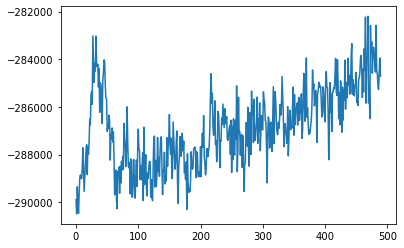

In [41]:
plt.plot(energies[10:])

## Try running vanilla MD on the 1200 K thermostate (with scaled water rest system) for ala dipeptide in vacuum and see if the problem happens

In [21]:
from tqdm import tqdm_notebook
import openmmtools

In [3]:
import pickle
import os
from openeye import oechem
from perses.annihilation.rest import RESTTopologyFactoryV2
from perses.annihilation.lambda_protocol import RESTStateV2
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
# cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


In [4]:
# Set temperatures
T_min = 300.0 * unit.kelvin
T = 1200 * unit.kelvin

# Create repartitioned hybrid system for lambda 0 endstate
atp, system_generator = generate_atp(phase='vacuum')
htf = generate_dipeptide_top_pos_sys(atp.topology,
                                     new_res='THR',
                                     system=atp.system,
                                     positions=atp.positions,
                                     system_generator=system_generator,
                                     conduct_htf_prop=True,
                                     repartitioned=True,
                                     endstate=0,
                                     validate_endstate_energy=False)
system = htf.hybrid_system



DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
IN

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 1.8337656028351002.
INFO:geometry:	reduced angle potential = 1.1919183319264113.
INFO:geometry:	reduced angle potential = 0.018091269364468077.
INFO:geometry:	reduced angle potential = 0.024541602803826057.
INFO:geometry:	reduced angle potential = 0.5173769600928078.
INFO:geometry:	reduced angle potential = 0.03520838491167304.
INFO:geometry:	reduced angle potential = 0.24812785173633503.
INFO:geometry:	reduced angle potential = 2.560367024753947.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle f

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -29.77277007124259
INFO:geometry:final reduced energy -20.656291970770887
INFO:geometry:sum of energies: -20.65628892953055
INFO:geometry:magnitude of difference in the energies: 3.041240336898454e-06
INFO:geometry:Final logp_proposal: 58.49511634428963


added energy components: [('CustomBondForce', 2.477068020167558), ('CustomAngleForce', 11.727100944892122), ('CustomTorsionForce', 19.549801627829826), ('CustomBondForce', -63.526740664132106)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 12, 13, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517324280898812.
INFO:geometry:	reduced angle potential = 3.2058324695160406e-13.
INFO:geometry:	reduced angle potential = 7.39096069988752e-11.
INFO:geometry:	reduced angle potential = 1.2915588460963948e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.672986687678176
INFO:geometry:final reduced energy 29.78946596595154
INFO:geometry:sum of energies: 29.789467829390215
INFO:geometry:magnitude of difference in the energies: 1.8634386762528266e-06
INFO:geometry:Final logp_proposal: -26846.303085669046


added energy components: [('CustomBondForce', 0.000520203927326505), ('CustomAngleForce', 0.4511197756248138), ('CustomTorsionForce', 7.250463344085812), ('CustomBondForce', 12.970883364040223)]


INFO:relative:*** Generating RepartitionedHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:H

In [9]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 2 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
radius = 0.3
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
factory = RESTTopologyFactoryV2(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)

INFO:REST:No MonteCarloBarostat added.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:REST:Handling constraints
INFO:REST:Handling bonds
INFO:REST:Handling angles
INFO:REST:Handling torsions
INFO:REST:Handling nonbondeds
INFO:REST:Handling nonbonded scaling (custom nb)
INFO:REST:Handling nonbonded exception scaling (custom bond)


In [15]:
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTStateV2.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

In [16]:
REST_system.getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9af862a50> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2af9455d5990> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2af9afbc89c0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2af9af99a540> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2af9af99ae40> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9455c0420> >]

In [17]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))


In [18]:
thermodynamic_state_list[0].get_system().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9af8a0120> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2af9af8a00f0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2af9af8a08a0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2af9af8a0db0> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2af9af8a0750> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9af8a0c90> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2af9af8a0990> >]

In [19]:
context_cache = cache.global_context_cache

In [22]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [23]:
context, integrator = context_cache.get_context(thermodynamic_state_list[-1], integrator)


In [24]:
context.getPlatform().getName()

'CUDA'

In [25]:
sampler_state_list[-1].apply_to_context(context)

In [26]:
old, new = list(), list()
energies = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    
    energy = context.getState(getEnergy=True).getPotentialEnergy()
    energies.append(energy.value_in_unit_system(unit.md_unit_system))
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    old.append(old_pos)
    new.append(new_pos)

<ipython-input-26-43269e18d264>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [27]:
with open("old_ala_vacuum_1200.npy", 'wb') as f:
    np.save(f, old)
with open("new_ala_vacuum_1200.npy", 'wb') as f:
    np.save(f, new)
with open("energies_ala_vacuum_1200.npy", 'wb') as f:
    np.save(f, energies)

In [28]:
import mdtraj as md

In [29]:
traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj.save("old_ala_vacuum_1200.dcd")
traj[0].save("old_ala_vacuum_1200.pdb")

In [30]:
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collecti

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

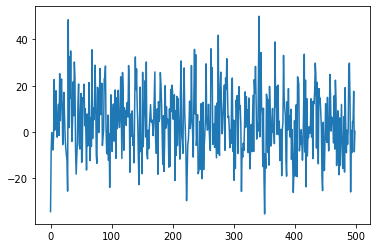

In [31]:
plt.plot(energies)

## Try running vanilla MD on the 1200 K thermostate (with scaled water rest system) for ala dipeptide in solvent and see if the problem happens

In [32]:
from tqdm import tqdm_notebook
import openmmtools

In [33]:
import pickle
import os
from openeye import oechem
from perses.annihilation.rest import RESTTopologyFactoryV2
from perses.annihilation.lambda_protocol import RESTStateV2
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
# cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


In [34]:
# Set temperatures
T_min = 300.0 * unit.kelvin
T = 1200 * unit.kelvin

# Create repartitioned hybrid system for lambda 0 endstate
atp, system_generator = generate_atp(phase='solvent')
htf = generate_dipeptide_top_pos_sys(atp.topology,
                                     new_res='THR',
                                     system=atp.system,
                                     positions=atp.positions,
                                     system_generator=system_generator,
                                     conduct_htf_prop=True,
                                     repartitioned=True,
                                     endstate=0,
                                     validate_endstate_energy=False)
system = htf.hybrid_system



DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}


making topology proposal


INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_generator:{9: 7}
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 17, 16, 13, 15, 19]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geomet

generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.24959740242789705.
INFO:geometry:	reduced angle potential = 0.9479110209922075.
INFO:geometry:	reduced angle potential = 0.09037203875505953.
INFO:geometry:	reduced angle potential = 1.912102277724299.
INFO:geometry:	reduced angle potential = 0.024522452522797795.
INFO:geometry:	reduced angle potential = 1.6020565189189082.
INFO:geometry:	reduced angle potential = 1.8127706109434323.
INFO:geometry:	reduced angle potential = 0.12377164641649234.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -60.383026911186946
INFO:geometry:final reduced energy -51.26654831135912
INFO:geometry:sum of energies: -51.2665457694749
INFO:geometry:magnitude of difference in the energies: 2.5418842142244102e-06
INFO:geometry:Final logp_proposal: 58.1484248972975


added energy components: [('CustomBondForce', 0.4488992402888311), ('CustomAngleForce', 10.333372862320974), ('CustomTorsionForce', 17.570614234757816), ('CustomBondForce', -88.73591324855458)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 13, 12, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.08012165173241896.
INFO:geometry:	reduced angle potential = 7.39096069988752e-11.
INFO:geometry:	reduced angle potential = 3.2058324695160406e-13.
INFO:geometry:	reduced angle potential = 1.2915588460963948e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.672986687678176
INFO:geometry:final reduced energy 29.78946596595156
INFO:geometry:sum of energies: 29.789467829390215
INFO:geometry:magnitude of difference in the energies: 1.8634386549365445e-06
INFO:geometry:Final logp_proposal: -27014.15599337589


added energy components: [('CustomBondForce', 0.000520203927326505), ('CustomAngleForce', 0.4511197756248138), ('CustomTorsionForce', 7.250463344085812), ('CustomBondForce', 12.970883364040223)]


INFO:relative:*** Generating RepartitionedHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 4
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.56477354, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.56477354, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.56477354), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:rel

In [35]:
# Create REST-ified hybrid system
res1 = list(htf.hybrid_topology.residues)[1]
rest_atoms = [atom.index for atom in list(res1.atoms)]
factory = RESTTopologyFactoryV2(system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)
REST_system = factory.REST_system

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.56477354, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.56477354, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.56477354), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:REST:Handling constraints
INFO:REST:Handling bonds
INFO:REST:Handling angles
INFO:REST:Handling torsions
INFO:REST:Handling nonbondeds
INFO:REST:Handling nonbonded scaling (custom nb)
INFO:REST:Handling nonbonded exception scaling (custom bond)


In [36]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 2 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
radius = 0.3
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
factory = RESTTopologyFactoryV2(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.56477354, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.56477354, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.56477354), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:REST:Handling constraints
INFO:REST:Handling bonds
INFO:REST:Handling angles
INFO:REST:Handling torsions
INFO:REST:Handling nonbondeds
INFO:REST:Handling nonbonded scaling (custom nb)
INFO:REST:Handling nonbonded exception scaling (custom bond)


In [37]:
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTStateV2.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

In [38]:
REST_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2af9af84fd50> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9af84fc90> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2af9affaa2d0> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2af9affaa1b0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2af9affaa1e0> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2af9affaacc0> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9affaa420> >]

In [39]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))


In [40]:
thermodynamic_state_list[0].get_system().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9e21d7ba0> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2af9e21d7b70> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2af9e21d78d0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2af9e21d7900> >,
 <simtk.openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2af9e21d7d80> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2af9e21d7b40> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2af9af3df150> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2af9af3df690> >]

In [41]:
context_cache = cache.global_context_cache

In [42]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [43]:
context, integrator = context_cache.get_context(thermodynamic_state_list[-1], integrator)


In [44]:
context.getPlatform().getName()

'CUDA'

In [45]:
sampler_state_list[-1].apply_to_context(context)

In [46]:
old, new = list(), list()
energies = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    
    energy = context.getState(getEnergy=True).getPotentialEnergy()
    energies.append(energy.value_in_unit_system(unit.md_unit_system))
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    old.append(old_pos)
    new.append(new_pos)

<ipython-input-46-43269e18d264>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [47]:
with open("old_ala_solvent_1200.npy", 'wb') as f:
    np.save(f, old)
with open("new_ala_solvent_1200.npy", 'wb') as f:
    np.save(f, new)
with open("energies_ala_solvent_1200.npy", 'wb') as f:
    np.save(f, energies)

In [48]:
import mdtraj as md

In [49]:
traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj.save("old_ala_solvent_1200.dcd")
traj[0].save("old_ala_solvent_1200.pdb")

In [50]:
import matplotlib.pyplot as plt

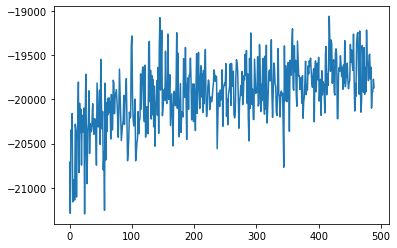

In [53]:
plt.plot(energies[10:])

## Try running vanilla MD on the 1200 K thermostate (with vanilla rest system) for alanine dipeptide in solvent and see if the problem happens

In [1]:
from tqdm import tqdm_notebook
import openmmtools

In [2]:
import pickle
import os
from openeye import oechem
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTState
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
# cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


conducting subsequent work with the following platform: CUDA


INFO:rdkit:Enabling RDKit 2021.03.3 jupyter extensions


In [3]:
# Set temperatures
T_min = 300.0 * unit.kelvin
T = 1200 * unit.kelvin

# Create repartitioned hybrid system for lambda 0 endstate
atp, system_generator = generate_atp(phase='solvent')
htf = generate_dipeptide_top_pos_sys(atp.topology,
                                     new_res='THR',
                                     system=atp.system,
                                     positions=atp.positions,
                                     system_generator=system_generator,
                                     conduct_htf_prop=True,
                                     repartitioned=True,
                                     endstate=0,
                                     validate_endstate_energy=False)
system = htf.hybrid_system



DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
IN

making topology proposal


INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 19, 13, 17, 15, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching fun

generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.52073636121504.
INFO:geometry:	reduced angle potential = 0.49495046990652297.
INFO:geometry:	reduced angle potential = 0.19164628663423405.
INFO:geometry:	reduced angle potential = 0.5418824591915944.
INFO:geometry:	reduced angle potential = 0.4375420127497755.
INFO:geometry:	reduced angle potential = 2.5650851401910777.
INFO:geometry:	reduced angle potential = 0.275570706471153.
INFO:geometry:	reduced angle potential = 1.8224845441562403.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	ther

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -63.80018747509166
INFO:geometry:final reduced energy -54.68370816700134
INFO:geometry:sum of energies: -54.68370633337962
INFO:geometry:magnitude of difference in the energies: 1.833621723790202e-06
INFO:geometry:Final logp_proposal: 58.13289887534244


added energy components: [('CustomBondForce', 2.5061004416340613), ('CustomAngleForce', 11.127585835334552), ('CustomTorsionForce', 16.555527070382837), ('CustomBondForce', -93.9894008224431)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 11, 13, 12]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517324280898812.
INFO:geometry:	reduced angle potential = 1.2915588460963948e-10.
INFO:geometry:	reduced angle potential = 7.39096069988752e-11.
INFO:geometry:	reduced angle potential = 3.2058324695160406e-13.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.672986687678176
INFO:geometry:final reduced energy 29.78946596595156
INFO:geometry:sum of energies: 29.789467829390215
INFO:geometry:magnitude of difference in the energies: 1.8634386549365445e-06
INFO:geometry:Final logp_proposal: -27056.246626179214


added energy components: [('CustomBondForce', 0.000520203927326505), ('CustomAngleForce', 0.4511197756248138), ('CustomTorsionForce', 7.250463344085812), ('CustomBondForce', 12.970883364040223)]


INFO:relative:*** Generating RepartitionedHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 4
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.56477354, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.56477354, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.56477354), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:rel

In [5]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 2 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
radius = 0.3
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
factory = RESTTopologyFactory(htf.hybrid_system, rest_atoms, use_dispersion_correction=True)

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.56477354, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.56477354, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.56477354), unit=nanometer)]
INFO:REST:No unknown forces.


In [6]:
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 300.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTState.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

In [7]:
REST_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ae2afd36b40> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ae2afd36960> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ae2afd36c30> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ae2afd36f00> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ae2afd36db0> >]

In [8]:
# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))


In [9]:
thermodynamic_state_list[0].get_system().getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ae2c0b119f0> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ae29e5c5d80> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ae29e5c5fc0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ae29e5c5cf0> >,
 <simtk.openmm.openmm.AndersenThermostat; proxy of <Swig Object of type 'OpenMM::AndersenThermostat *' at 0x2ae29e4f1cf0> >,
 <simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ae29e4f1e10> >]

In [10]:
context_cache = cache.global_context_cache

In [11]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [12]:
context, integrator = context_cache.get_context(thermodynamic_state_list[-1], integrator)


In [13]:
context.getPlatform().getName()

'CUDA'

In [14]:
sampler_state_list[-1].apply_to_context(context)

In [15]:
old, new = list(), list()
energies = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    
    energy = context.getState(getEnergy=True).getPotentialEnergy()
    energies.append(energy.value_in_unit_system(unit.md_unit_system))
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    old.append(old_pos)
    new.append(new_pos)

<ipython-input-15-43269e18d264>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
with open("old_ala_solvent_vanilla_rest_1200.npy", 'wb') as f:
    np.save(f, old)
with open("new_ala_solvent_vanilla_rest_1200.npy", 'wb') as f:
    np.save(f, new)
with open("energies_ala_solvent_vanilla_rest_1200.npy", 'wb') as f:
    np.save(f, energies)

In [17]:
import mdtraj as md

In [18]:
traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
traj.save("old_ala_solvent_vanilla_rest_1200.dcd")
traj[0].save("old_ala_solvent_vanilla_rest_1200.pdb")

In [19]:
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collecti

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


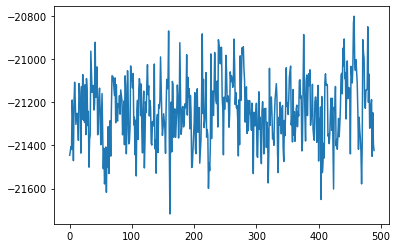

In [21]:
plt.plot(energies[10:])